In [1]:
# util for SFG DRO
import torch
from sklearn.kernel_approximation import RBFSampler
from torch import nn
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import euclidean_distances
from torch.optim.swa_utils import AveragedModel  # average model weights
import torch.optim as optim



class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.shape[0], -1)

# This function builds the model for one-vs-all classification
def buildModel(task=None, method=None,n_hidden=100, device=None, loss_reduction='mean'):
    n_output = 1  # Only one output node for one-vs-all classification
    loss_erm = nn.BCEWithLogitsLoss(reduction=loss_reduction)  # Binary Cross-Entropy Loss
    
    # Defining the model architecture
    modelDecision = nn.Sequential(
        Flatten(), 
        nn.Linear(784, n_hidden), 
        nn.ReLU(), 
        nn.Linear(n_hidden, n_hidden), 
        nn.ReLU(), 
        nn.Linear(n_hidden, n_output)
    ).to(device)
    
    return modelDecision, loss_erm

def computeErr(yp, y,task=None,shuffle_test=False):
    predictions = (yp > 0).float()  # Converting model outputs to binary predictions
    err = (predictions != y).float().mean().item()  # Calculating the error rate
    return err





In [2]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

def cifar100Data(task='one_vs_all', class_num=0, batch_size=100, shuffle_test=False):
    if class_num < 0 or class_num > 99:  # Changed this line to check for 100 classes instead of 10
        raise ValueError("class_num should be between 0 and 99")  # Updated the error message

    # Applying necessary transforms on the CIFAR-100 data including grayscale and resize
    transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize((28, 28)),
        transforms.ToTensor()
    ])

    # Fetching CIFAR-100 data
    cifar100_train = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)  # Changed to CIFAR100
    cifar100_test = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)  # Changed to CIFAR100
    
    if task == 'one_vs_all':
        cifar100_train.targets = (np.array(cifar100_train.targets) == class_num).astype(float)
        cifar100_test.targets = (np.array(cifar100_test.targets) == class_num).astype(float)
    elif task == 'multi':
        pass
    else:
        raise NotImplementedError

    train_loader = DataLoader(cifar100_train, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(cifar100_test, batch_size=batch_size, shuffle=shuffle_test)

    return train_loader, test_loader



In [4]:
def apply_gd(x, step_gamma=0.1):
    if x.grad is None:
        return x
    xnew = x - step_gamma * x.grad.detach()
    x.grad.data.zero_()
    return xnew


# a general loss function
def loss_general_se(output, target):
    return torch.sum((output - target) ** 2, dim=1).reshape(-1, 1)


def sample_zeta(X, y, zeta_sample_method=None, loss_erm=None, modelDecision=None, n_sample_zeta=1, epsilon_attack=0.0, learn_task=None, F=None):
    Z = None
    yperturb = None

    for _ in range(n_sample_zeta):
        delta = zeta_sample_method(loss_erm, modelDecision, X, y, randomize=True, epsilon=epsilon_attack,
                                   alpha=0.01, num_iter=20, task=learn_task, mklF=F)  # used with the new pgd
        # delta = attack(loss_erm, modelDecision, X, y, randomize=True, epsilon=1.0, alpha=0.01, num_iter=20, task=learn_task, rkhsF=F) # used with the new pgd

        Zperturb = X + delta
        if Z is not None:  # also penalize the original loss at unperturbed data
            Z = torch.cat((Zperturb, Z))  # cat new perturb Z with the old
            yperturb = torch.cat((yperturb, y))
        else:
            Z = Zperturb
            yperturb = y

    return Z, yperturb

In [5]:
def sfg_train_step(X=None, y=None, just_rand=None, loss_erm=None, modelDecision=None, n_sample_zeta=None, epsilon_attack=None,
                   learn_task=None, F=None, epsilon=None, stat_plot=None, i_decay_csa=None, is_step_const=None,
                   model_class=None, modelSWA=None):
    Z, y = sample_zeta(X, y, zeta_sample_method=just_rand, loss_erm=loss_erm,
                       modelDecision=modelDecision, n_sample_zeta=n_sample_zeta,
                       epsilon_attack=epsilon_attack, learn_task=learn_task, F=F)
    yp = evalutateErmModel(modelDecision, Z,
                           task=learn_task)  # use original model in ERM to run thru data X
    # kdro surrogate loss
    f_emp = torch.mean(F(X, fit=True))  # emp loss under emp loss
    # '''KDRO obj'''
    obj = f_emp + epsilon * F.norm()  # obj of the optimization problem
    #  original loss l eval on z
    loss_emp = loss_erm(yp, y).reshape(-1, 1)
    assert loss_emp.shape == F(Z).shape
    cons_sip = loss_emp - F(Z)  # constraint function of SIP. G(th, zeta)
    partial_moment = 1
    if partial_moment:  # use functional constr: E h(l-f) = 0
        max_cons_g = torch.mean(torch.nn.functional.relu(cons_sip))
    else:
        max_cons_g, id_max = torch.max(cons_sip, 0)  # max of violation across all samples zeta
    # bookeeping
    stat_plot["max_cons_violation"].append(max_cons_g.data.detach())
    stat_plot["obj"].append(obj.data.detach())

    '''CSA - SGD step size'''
    # threshold
    threshold_csa = 0.1 / np.sqrt(i_decay_csa + 1)  # decay threhold
    # threshold_csa = 0.01 # constant step
    # step size
    if is_step_const:
        step_csa = 0.01
    else:
        step_csa = 0.1 / np.sqrt(i_decay_csa + 1)  # decay threhold
    i_decay_csa += 1
    # %% update dec var: th, f0, f
    # zero gradient before backward
    try:
        for w in modelDecision.parameters(): w.grad.data.zero_()
        for w in F.model.parameters(): w.grad.data.zero_()
    except:
        pass
    if max_cons_g <= threshold_csa:  # if constr satisfied
        obj.backward()
        # there is no th update since obj doens't have th in it

        # %% if cons. satisfied, polyak averaging to keep track of average
        if model_class == 'mlp':
            modelSWA.update_parameters(modelDecision)  # model with averaged weights
            # pass
        else:
            raise NotImplementedError

    else:  # cons violation
        if partial_moment:
            max_cons_g.backward()  # diff this:  E h(l-f)
        else:
            cons_sip[id_max].backward()

        # update model var
        if model_class == 'mlp':
            for weight in modelDecision.parameters():
                weight.data = apply_gd(weight, step_csa)
        else:
            raise NotImplementedError
    # update f0, weights of f
    for weight in F.model.parameters():
        weight.data = apply_gd(weight, step_csa)
    return i_decay_csa, stat_plot


In [6]:
def run_test(test_loader, modelERM, loss_erm, loaded, attack_function=None, attack_range=None, task=None, n_test=100, device=None):
    D = {'err': [], 'attack': [], 'sig': []}
    for attack_strength in attack_range:
        i_test = 0

        err_this_attack = []
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            if task=='binary' or task=='one_vs_all':
                y = y.float()
            i_test += 1
            if i_test > n_test:
                break

            delta = attack_function(loss_erm, modelERM, X, y, attack_strength, task=task)

            # evaluate attack
            #         plt.figure()
            yp = evalutateErmModel(loaded['model'], X + delta, task=task)
            err_kdro = computeErr(yp, y, task=task)

            err_this_attack.append(deepcopy(err_kdro))

        # for each attack, compute average
        D['err'].append(np.mean(err_this_attack))
        D['sig'].append(np.std(err_this_attack))
        D['attack'].append(attack_strength)

    D['n_run'] = len(err_this_attack)  # total number of runs
    D['eps_dro'] = loaded['epsilon']
    D['is_erm'] = loaded['is_erm']
    try:
        D['is_pgd'] = loaded['is_pgd']
    except:
        pass

    D['task'] = task

    return D



In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as Fa

class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)

class MKLfunction(nn.Module):
    def __init__(self, input_shape, model=None, gamma=None, degree=3, coef0=1, kernel_list=None):
        super(MKLfunction, self).__init__()
        self.model = model
        self.input_shape = input_shape
        self.gamma = gamma
        self.degree = degree
        self.coef0 = coef0
        
        self.flatten = Flatten()  # Instantiate the Flatten module
        self.kernel_list = kernel_list or [self.rbf_kernel_torch, self.polynomial_kernel_torch]
        self.kernel_weights = nn.Parameter(torch.ones(len(self.kernel_list)), requires_grad=True)

    def rbf_kernel_torch(self, X, Y=None):
        X = self.flatten(X)
        Y = self.flatten(Y) if Y is not None else X
        gamma = self.gamma if self.gamma is not None else 1.0 / X.size(1)
        
        sq_norms_X = torch.sum(X**2, dim=1)
        sq_norms_Y = torch.sum(Y**2, dim=1)
        cross_products = torch.mm(X, Y.t())
        distances = sq_norms_X[:, None] + sq_norms_Y[None, :] - 2 * cross_products
        return torch.exp(-gamma * distances)

    def polynomial_kernel_torch(self, X, Y=None):
        X = self.flatten(X)
        Y = self.flatten(Y) if Y is not None else X
        products = torch.mm(X, Y.t())
        return (products + self.coef0)**self.degree

    def compute_combined_kernel(self, X):
        X_tensor = X.clone().detach().requires_grad_(True)
        kernel_matrices = [k(X_tensor) for k in self.kernel_list]
        normalized_weights = Fa.softmax(self.kernel_weights, dim=0)
        K_combined = sum(w * km for w, km in zip(normalized_weights, kernel_matrices))
        return K_combined

    def forward(self, X, fit=False):
        K_combined = self.compute_combined_kernel(X)
        
        # Ensure that the model is correctly defined for the shape of K_combined
        if self.model is None or self.model[1].in_features != K_combined.shape[1]:
            self.model = nn.Sequential(Flatten(), nn.Linear(K_combined.shape[1], 1, bias=True))

        mklF = self.model(K_combined)
        return mklF

    def norm(self):
        return torch.norm(self.kernel_weights)


In [8]:



def evalutateErmModel(modelDecision, X, task=None):
    yp = modelDecision(X.view(X.shape[0], -1)).squeeze()  # No need for indexing in one-vs-all
    return yp






In [9]:
def pgd_linf(loss_attack, model, X, y, epsilon=1.0, alpha=0.01, num_iter=20, randomize=False, task=None):
    """ Construct PGD adversarial examples on the examples X"""
    if randomize:
        delta = torch.rand_like(X, requires_grad=True)
        delta.data = delta.data * 2 * epsilon - epsilon
    else:
        delta = torch.zeros_like(X, requires_grad=True)

    for t in range(num_iter):
        loss = loss_attack(evalutateErmModel(model, X + delta, task=task), y)
        if loss.numel() != 1:  # This is to check if the tensor is not a scalar
            loss = loss.sum()  # Or use mean(), depending on your specific requirements
        loss.backward()

        delta.data = (delta + alpha * delta.grad.detach().sign()).clamp(-epsilon, epsilon)
        delta.grad.zero_()

    # for w in model.parameters(): w.grad.data.zero_()
        # for w in rkhsF.model.parameters(): w.grad.data.zero_()
    return delta.detach()


def just_rand(loss_attack, model, X, y, epsilon=1.0, alpha=0.01, num_iter=20, randomize=False, task=None, **kwargs):
    """ just use random noises to sample new samples"""
    delta = torch.rand_like(X, requires_grad=False)
    delta.data = 2* (delta.data - 0.5) * epsilon

    return delta.detach()

In [10]:
# params
n_epoch_gd = 10# how many epochs of SFG to run
learn_task = 'one_vs_all'
mini_batch = 50
model_class = 'mlp'
loss_reduction = 'none'
n_rand_feat = 500
n_sample_zeta = 150
epsilon_attack = 0.5  # largest perturbation of the domain allowed in RO
epsilon = 1.0  # Kernel DRO ambiguity size
is_step_const = 0  # use decay step size
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# set up
train_loader, test_loader = cifar100Data(task=learn_task, batch_size=mini_batch)
modelDecision, loss_erm = buildModel(task=learn_task, method=model_class, n_hidden=64, device=device,
                                     loss_reduction=loss_reduction)
modelSWA = AveragedModel(modelDecision)


X_initial, y_initial = next(iter(train_loader))
X_initial = X_initial.requires_grad_(True).to(device)

# Define the model to be used within MKLfunction
input_features = X_initial.shape[1] * X_initial.shape[2] * X_initial.shape[3]
mkl_model = nn.Sequential(
    Flatten(),
    nn.Linear(input_features, 96),  # Adjust the output features as needed
    nn.ReLU(),
    nn.Linear(96, 1)
).to(device)

# Instantiate the MKLfunction with the newly defined model
F = MKLfunction(X_initial.shape, model=mkl_model)
# Bookkeeping
stat_plot = {"max_cons_violation": [], "obj": []}

Files already downloaded and verified
Files already downloaded and verified


In [11]:
from tqdm import tqdm

print("=========Training SFG DRO=========")

i_decay_csa = 0  # counter for threshold decay

# Wrapping the range function with tqdm to get progress bar for epochs
for i_epoch in tqdm(range(n_epoch_gd), desc="Epochs"):
    # Wrapping the train_loader with tqdm to get progress bar for batches
    for X, y in tqdm(train_loader, desc="Batches", leave=False):
        X, y = X.to(device), y.to(device)
        if learn_task=='binary' or learn_task=='one_vs_all':
            y = y.float()

        i_decay_csa, stat_plot = sfg_train_step(X=X, y=y, just_rand=just_rand, loss_erm=loss_erm,
                                                modelDecision=modelDecision, n_sample_zeta=n_sample_zeta,
                                                epsilon_attack=epsilon_attack,
                                                learn_task=learn_task, F=F, epsilon=epsilon, stat_plot=stat_plot,
                                                i_decay_csa=i_decay_csa,
                                                is_step_const=is_step_const,
                                                model_class=model_class, modelSWA=modelSWA)
    print('epoch:', i_epoch, '/', n_epoch_gd)

print("=========Training Finished=========")

=========Training SFG DRO=========


Batches:  13%|█▎        | 126/1000 [27:05<3:14:41, 13.37s/it]


Batches:  25%|██▌       | 252/1000 [57:37<2:58:33, 14.32s/it]


Batches:  37%|███▋      | 374/1000 [1:24:00<2:25:18, 13.93s/it]


Batches:  50%|████▉     | 496/1000 [1:49:27<1:44:45, 12.47s/it]


Batches:  62%|██████▏   | 618/1000 [2:12:02<1:05:25, 10.28s/it]


Batches:  74%|███████▍  | 743/1000 [2:31:09<33:56,  7.92s/it]


Batches:  87%|████████▋ | 869/1000 [2:50:42<17:05,  7.83s/it]


Batches: 100%|█████████▉| 995/1000 [3:09:57<00:51, 10.38s/it]


Epochs:  10%|█         | 1/10 [3:10:46<28:36:59, 11446.59s/it]

epoch: 0 / 10



Batches:  13%|█▎        | 126/1000 [20:19<2:39:46, 10.97s/it]


Batches:  25%|██▌       | 252/1000 [40:50<1:48:35,  8.71s/it]


Batches:  38%|███▊      | 377/1000 [1:00:14<1:37:24,  9.38s/it]


Batches:  50%|████▉     | 499/1000 [1:19:22<1:24:35, 10.13s/it]


Batches:  62%|██████▏   | 621/1000 [1:41:10<59:55,  9.49s/it]  


Batches:  75%|███████▍  | 746/1000 [2:02:58<44:06, 10.42s/it]


Batches:  87%|████████▋ | 872/1000 [2:22:01<17:25,  8.16s/it]


Batches: 100%|█████████▉| 998/1000 [2:42:08<00:21, 10.65s/it]


Epochs:  20%|██        | 2/10 [5:53:18<23:13:16, 10449.55s/it]

epoch: 1 / 10



Batches:  13%|█▎        | 126/1000 [21:05<2:03:46,  8.50s/it]


Batches:  25%|██▌       | 252/1000 [40:26<1:39:59,  8.02s/it]


Batches:  38%|███▊      | 377/1000 [1:00:37<1:43:44,  9.99s/it]


Batches:  50%|████▉     | 499/1000 [1:17:36<1:08:08,  8.16s/it]


Batches:  62%|██████▏   | 622/1000 [1:34:33<47:31,  7.54s/it]


Batches:  75%|███████▍  | 747/1000 [1:54:03<36:51,  8.74s/it]


Batches:  87%|████████▋ | 873/1000 [2:12:13<21:31, 10.17s/it]


Batches: 100%|█████████▉| 999/1000 [2:33:11<00:08,  8.70s/it]


Epochs:  30%|███       | 3/10 [8:26:35<19:12:23, 9877.59s/it] 

epoch: 2 / 10



Batches:  13%|█▎        | 126/1000 [19:37<1:54:47,  7.88s/it]


Batches:  25%|██▌       | 252/1000 [40:10<2:17:35, 11.04s/it]


Batches:  38%|███▊      | 377/1000 [1:01:15<1:20:24,  7.74s/it]


Batches:  50%|████▉     | 499/1000 [1:19:33<1:32:36, 11.09s/it]


Batches:  62%|██████▏   | 621/1000 [1:40:10<1:04:00, 10.13s/it]


Batches:  75%|███████▍  | 746/1000 [2:01:03<41:18,  9.76s/it]


Batches:  87%|████████▋ | 872/1000 [2:21:47<16:21,  7.67s/it]


Batches: 100%|█████████▉| 998/1000 [2:41:55<00:22, 11.06s/it]


Epochs:  40%|████      | 4/10 [11:08:48<16:22:03, 9820.63s/it]

epoch: 3 / 10



Batches:  13%|█▎        | 126/1000 [20:31<2:24:16,  9.90s/it]


Batches:  25%|██▌       | 252/1000 [40:28<1:59:59,  9.63s/it]


Batches:  38%|███▊      | 377/1000 [1:01:09<1:34:11,  9.07s/it]


Batches:  50%|████▉     | 499/1000 [1:19:20<1:09:55,  8.37s/it]


Batches:  62%|██████▏   | 621/1000 [1:38:44<1:02:51,  9.95s/it]


Batches:  75%|███████▍  | 746/1000 [1:57:53<40:04,  9.47s/it]


Batches:  87%|████████▋ | 872/1000 [2:18:10<18:29,  8.67s/it]


Batches: 100%|█████████▉| 998/1000 [2:37:54<00:20, 10.43s/it]


Epochs:  50%|█████     | 5/10 [13:47:03<13:28:35, 9703.13s/it]

epoch: 4 / 10



Batches:  13%|█▎        | 126/1000 [17:49<1:48:33,  7.45s/it]


Batches:  25%|██▌       | 252/1000 [35:39<1:37:23,  7.81s/it]


Batches:  38%|███▊      | 378/1000 [54:07<1:20:43,  7.79s/it]


Batches:  50%|█████     | 501/1000 [1:12:23<1:18:27,  9.43s/it]


Batches:  62%|██████▏   | 623/1000 [1:29:50<57:48,  9.20s/it]


Batches:  75%|███████▍  | 749/1000 [1:48:14<37:03,  8.86s/it]


Batches:  88%|████████▊ | 875/1000 [2:07:13<21:06, 10.13s/it]


Epochs:  60%|██████    | 6/10 [16:12:37<10:24:54, 9373.67s/it]

epoch: 5 / 10



Batches:  13%|█▎        | 126/1000 [18:56<2:26:36, 10.07s/it]


Batches:  25%|██▌       | 252/1000 [37:19<2:01:50,  9.77s/it]


Batches:  38%|███▊      | 378/1000 [56:13<1:47:48, 10.40s/it]


Batches:  50%|█████     | 501/1000 [1:15:51<1:17:48,  9.36s/it]


Batches:  62%|██████▏   | 623/1000 [1:35:14<58:11,  9.26s/it]  


Batches:  75%|███████▍  | 748/1000 [1:54:03<38:00,  9.05s/it]


Batches:  87%|████████▋ | 874/1000 [2:13:09<19:17,  9.19s/it]


Batches: 100%|██████████| 1000/1000 [2:32:40<00:00,  8.38s/it]


Epochs:  70%|███████   | 7/10 [18:45:17<7:45:11, 9303.98s/it] 

epoch: 6 / 10



Batches:  13%|█▎        | 126/1000 [18:45<2:08:27,  8.82s/it]


Batches:  25%|██▌       | 252/1000 [37:28<1:58:29,  9.51s/it]


Batches:  38%|███▊      | 378/1000 [55:34<1:36:58,  9.35s/it]


Batches:  50%|█████     | 501/1000 [1:13:34<1:14:52,  9.00s/it]


Batches:  62%|██████▏   | 624/1000 [1:31:27<50:54,  8.12s/it]


Batches:  75%|███████▍  | 749/1000 [1:49:32<35:29,  8.49s/it]


Batches:  88%|████████▊ | 875/1000 [2:07:09<17:42,  8.50s/it]


Epochs:  80%|████████  | 8/10 [21:10:45<5:04:00, 9120.39s/it] 

epoch: 7 / 10



Batches:  13%|█▎        | 126/1000 [18:33<2:02:46,  8.43s/it]


Batches:  25%|██▌       | 252/1000 [36:30<1:45:50,  8.49s/it]


Batches:  38%|███▊      | 378/1000 [54:52<1:21:55,  7.90s/it]


Batches:  50%|█████     | 501/1000 [1:12:24<1:08:29,  8.24s/it]


Batches:  62%|██████▏   | 624/1000 [1:29:52<45:59,  7.34s/it]


Batches:  75%|███████▌  | 750/1000 [1:47:41<37:18,  8.95s/it]


Batches:  88%|████████▊ | 876/1000 [2:06:15<19:35,  9.48s/it]


Epochs:  90%|█████████ | 9/10 [23:34:51<2:29:32, 8972.23s/it] 

epoch: 8 / 10



Batches:  13%|█▎        | 126/1000 [18:08<1:53:09,  7.77s/it]


Batches:  25%|██▌       | 252/1000 [35:55<1:34:10,  7.55s/it]


Batches:  38%|███▊      | 378/1000 [54:15<1:29:20,  8.62s/it]


Batches:  50%|█████     | 501/1000 [1:11:53<1:12:46,  8.75s/it]


Batches:  62%|██████▏   | 624/1000 [1:30:06<59:36,  9.51s/it]


Batches:  75%|███████▍  | 749/1000 [1:48:35<37:22,  8.93s/it]


Batches:  88%|████████▊ | 875/1000 [2:06:26<15:02,  7.22s/it]


Epochs: 100%|██████████| 10/10 [25:58:31<00:00, 9351.13s/it]  

epoch: 9 / 10
=========Training Finished=========


In [12]:
import torch
import torch.nn as nn
import torch.optim as optim

# Load old model details
loaded_old = torch.load('model_erm.pkl')

# Extract parameters to build a similar architecture
learn_task = 'one_vs_all'
model_class = loaded_old['model_class']
epsilon = loaded_old['epsilon']
epsilon_attack = loaded_old['epsilon_attack']
is_erm = loaded_old['is_erm']
is_pgd = loaded_old['is_pgd']
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create a new model with the same architecture but with initialized weights
modelERM, loss_erm = buildModel(task=learn_task, method=model_class, n_hidden=64, device=device)

# Depending on the values of is_erm and is_pgd, you may modify the loss function or optimization
if is_erm:
    # Implement specific code for ERM, if needed
    pass

if is_pgd:
    # Implement specific code for PGD, if needed
    pass

# Define the optimizer
optimizer = optim.SGD(modelERM.parameters(), lr=0.01, momentum=0.9)

# Stat dictionary for collecting statistics during training
stat = {"loss": [], "accuracy": []}

# Training loop
for epoch in range(10):  # Adjust the number of epochs as needed
    for X, y in train_loader:  # Assume that train_loader is defined and contains the new data
        X, y = X.to(device), y.to(device)
        if learn_task == 'binary' or learn_task == 'one_vs_all':
            y = y.float()

        # Forward pass
        outputs = modelERM(X)
        loss = loss_erm(outputs.squeeze(), y)
        
        # Collect stats
        stat['loss'].append(loss.item())
        # Add other statistics as needed

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/10], Loss: {loss.item():.4f}")





Epoch [1/10], Loss: 0.0175
Epoch [2/10], Loss: 0.0473
Epoch [3/10], Loss: 0.2131
Epoch [4/10], Loss: 0.0095
Epoch [5/10], Loss: 0.1001
Epoch [6/10], Loss: 0.0587
Epoch [7/10], Loss: 0.1104
Epoch [8/10], Loss: 0.0056
Epoch [9/10], Loss: 0.0167
Epoch [10/10], Loss: 0.0119


In [13]:
torch.save({
    'model': modelERM,
    'model_no_avg': loaded_old['model_no_avg'],
    'model_class': model_class,
    'epsilon': epsilon,
    'epsilon_attack': epsilon_attack,
    'stat': stat,  # Updated to save the collected stats
    'is_erm': is_erm,
    'is_pgd': is_pgd,
    'task': learn_task
}, 'mnist_new_model_erm.pth')

# Loading the entire model, including its architecture

loaded = torch.load('mnist_new_model_erm.pth')
modelERM = loaded['model']
modelERM.to(device)
modelERM.eval()  # Set the model to evaluation mode



_, loss_erm = buildModel(task=learn_task, method='linear', n_hidden = 1, device=device) 

# Load some data
for X, y in test_loader:
    X, y = X.to(device), y.to(device)
    if learn_task == 'binary' or learn_task == 'one_vs_all':
        y = y.float()
    break
    
# Create an attack
level_atk = 0.2
atk = pgd_linf

delta_final = atk(loss_erm, modelERM, X, y, level_atk, task=learn_task)

M, N = 2, 9

In [14]:
from copy import deepcopy
import numpy as np


# Run attacks and collect error rates for the models
attack_range = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]

# Evaluate SWA model (SFG DRO)
results_sfg_MKL = run_test(test_loader=test_loader, modelERM=modelSWA, 
                       loss_erm=loss_erm, loaded=loaded, attack_function=pgd_linf, 
                       attack_range=attack_range, task=learn_task, n_test=100, device=device)



In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline

def plot_error_rates(results, labels, colors, markers, title):
    """
    Plot error rates under adversarial attacks.

    Parameters:
    - results: a list of dictionaries containing 'attack', 'err', and 'sig' keys
    - labels: a list of string labels for the legend
    - colors: a list of string colors for the plot lines
    - markers: a list of string markers for the error bar
    - title: a string title for the plot
    """

    plt.figure(figsize=(10, 6))

    for result, label, color, marker in zip(results, labels, colors, markers):
        xnew = np.linspace(min(result['attack']), max(result['attack']), 300) 
        spl = make_interp_spline(result['attack'], result['err'], k=3)
        ynew = spl(xnew)
        plt.plot(xnew, ynew, color=color, label=label)
        plt.errorbar(result['attack'], result['err'], yerr=result['sig'], 
                     fmt=marker, capsize=5, color=color, linestyle='None')
    
    plt.xlabel('Attack strength')
    plt.ylabel('Error rate')
    plt.title(title)
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.show()

    print("Error Rates under Adversarial Attacks:\n")
    print("Attack Strength", end="\t\t")
    for label in labels:
        print(label, end="\t\t")
    print("\n" + "-" * 50)

    for i in range(len(results[0]['attack'])):
        print("{:.2f}".format(results[0]['attack'][i]), end="\t\t\t")
        for result in results:
            print("{:.4f}".format(result['err'][i]), end="\t\t\t")
        print()


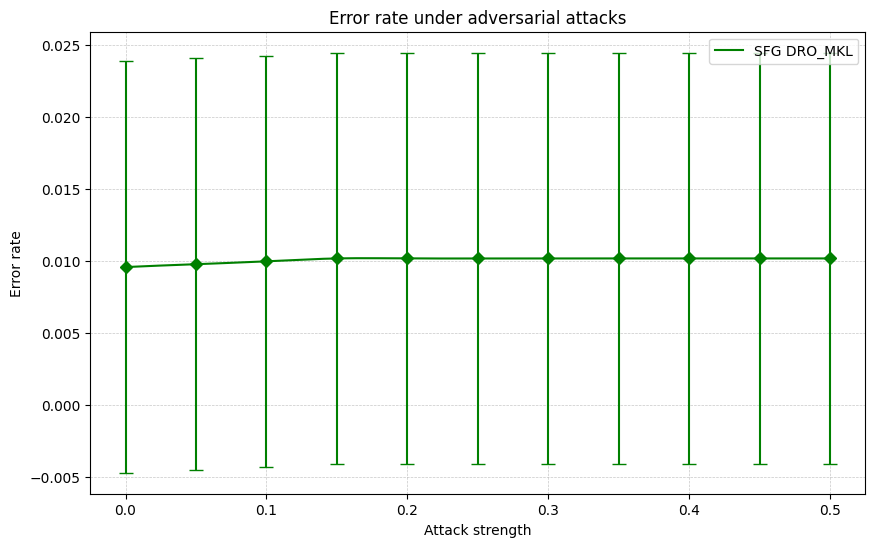

Error Rates under Adversarial Attacks:

Attack Strength		SFG DRO_MKL		
--------------------------------------------------
0.00			0.0096			
0.05			0.0098			
0.10			0.0100			
0.15			0.0102			
0.20			0.0102			
0.25			0.0102			
0.30			0.0102			
0.35			0.0102			
0.40			0.0102			
0.45			0.0102			
0.50			0.0102			


In [16]:
results = [results_sfg_MKL]

# Corresponding labels for the legend
labels = ['SFG DRO_MKL']

# Colors for the plot lines
colors = ['green', ]

# Markers for the error bar
markers = ['D', 's']  # D is for diamond shape, s is for square shape

# Title for the plot
title = 'Error rate under adversarial attacks'

# Call the function to plot error rates
plot_error_rates(results, labels, colors, markers, title)